In [1]:
import sys
sys.path.insert(0, '../../../utils/')

In [2]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams['figure.dpi']= 500
sns.set_context("notebook")
sns.set(style="white")

In [3]:
from top_genes import latent_dim_participation_in_clusters, indices_of_top_k, select_genes_by_latent_dim, merged_count, mean_of_attention_heads

In [4]:
LATENT_DIM = 50

In [5]:
l1_weight = torch.load('attn_layers_weights/pbmc3k_hidden_layer_1_weight.pt')
l2_weight = torch.load('attn_layers_weights/pbmc3k_hidden_layer_2_weight.pt')
l_mean_weight = torch.load('attn_layers_weights/pbmc3k_hidden_layer_mean_weight.pt')
l_std_weight = torch.load('attn_layers_weights/pbmc3k_hidden_layer_std_weight.pt')

In [6]:
mm1 = torch.mm(l1_weight.T, l2_weight.T)
mean_layer_prod = torch.mm(mm1, l_mean_weight.T)
std_layer_prod = torch.mm(mm1, l_std_weight.T)

merged_mean_layer = mean_of_attention_heads(mean_layer_prod, LATENT_DIM)
merged_std_layer = mean_of_attention_heads(std_layer_prod, LATENT_DIM)

In [7]:
merged_mean_layer.shape

torch.Size([250, 50])

In [8]:
merged_std_layer.shape

torch.Size([250, 50])

In [9]:
cellvgae_node_embs = np.load('CellVGAE/cellvgae_node_embs.npy')
cellvgae_umap = np.load('CellVGAE/cellvgae_umap.npy')
cellvgae_clusters = np.load('CellVGAE/cellvgae_clusters.npy')

In [10]:
hvg250 = pd.read_csv('PBMC3k_HVG_250.csv')

In [11]:
idx_to_gene = dict(zip(range(len(hvg250['Unnamed: 0'].values)), hvg250['Unnamed: 0'].values))

In [12]:
gene_to_idx = {v: k for k, v in idx_to_gene.items()}

In [13]:
latent_diff_clusters = latent_dim_participation_in_clusters(cellvgae_node_embs, cellvgae_clusters)

In [14]:
latent_diff_clusters_head =  latent_diff_clusters.sort_values(['Cluster','Percentage'],ascending=False).groupby('Cluster').head(10)

## Plot of multiple genes

In [15]:
# genes_of_interest = ['C1QB', 'CCL5', 'CD74', 'CD79A', 'CLEC1B', 'FCGR3A', 'KLRG1', 'LST1', 'LYPD2', 'LYZ', 'PRF1', 'S100A8', 'S100A9']
genes_of_interest = ['NKG7', 'CD74', 'CD79A', 'LYZ', 'FCGR3A', 'KLRG1', 'COTL1', 'S100A9']

In [16]:
len(genes_of_interest)

8

In [17]:
plt.rcParams["font.size"] = 7
sns.set_style('white')

In [18]:
genes_to_hues = {gene: np.matmul(cellvgae_node_embs, merged_mean_layer[gene_to_idx[gene], :].detach().numpy()) for gene in genes_of_interest}

<ipython-input-19-fcaee4ed656c>:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=1.5, h_pad=3.5)


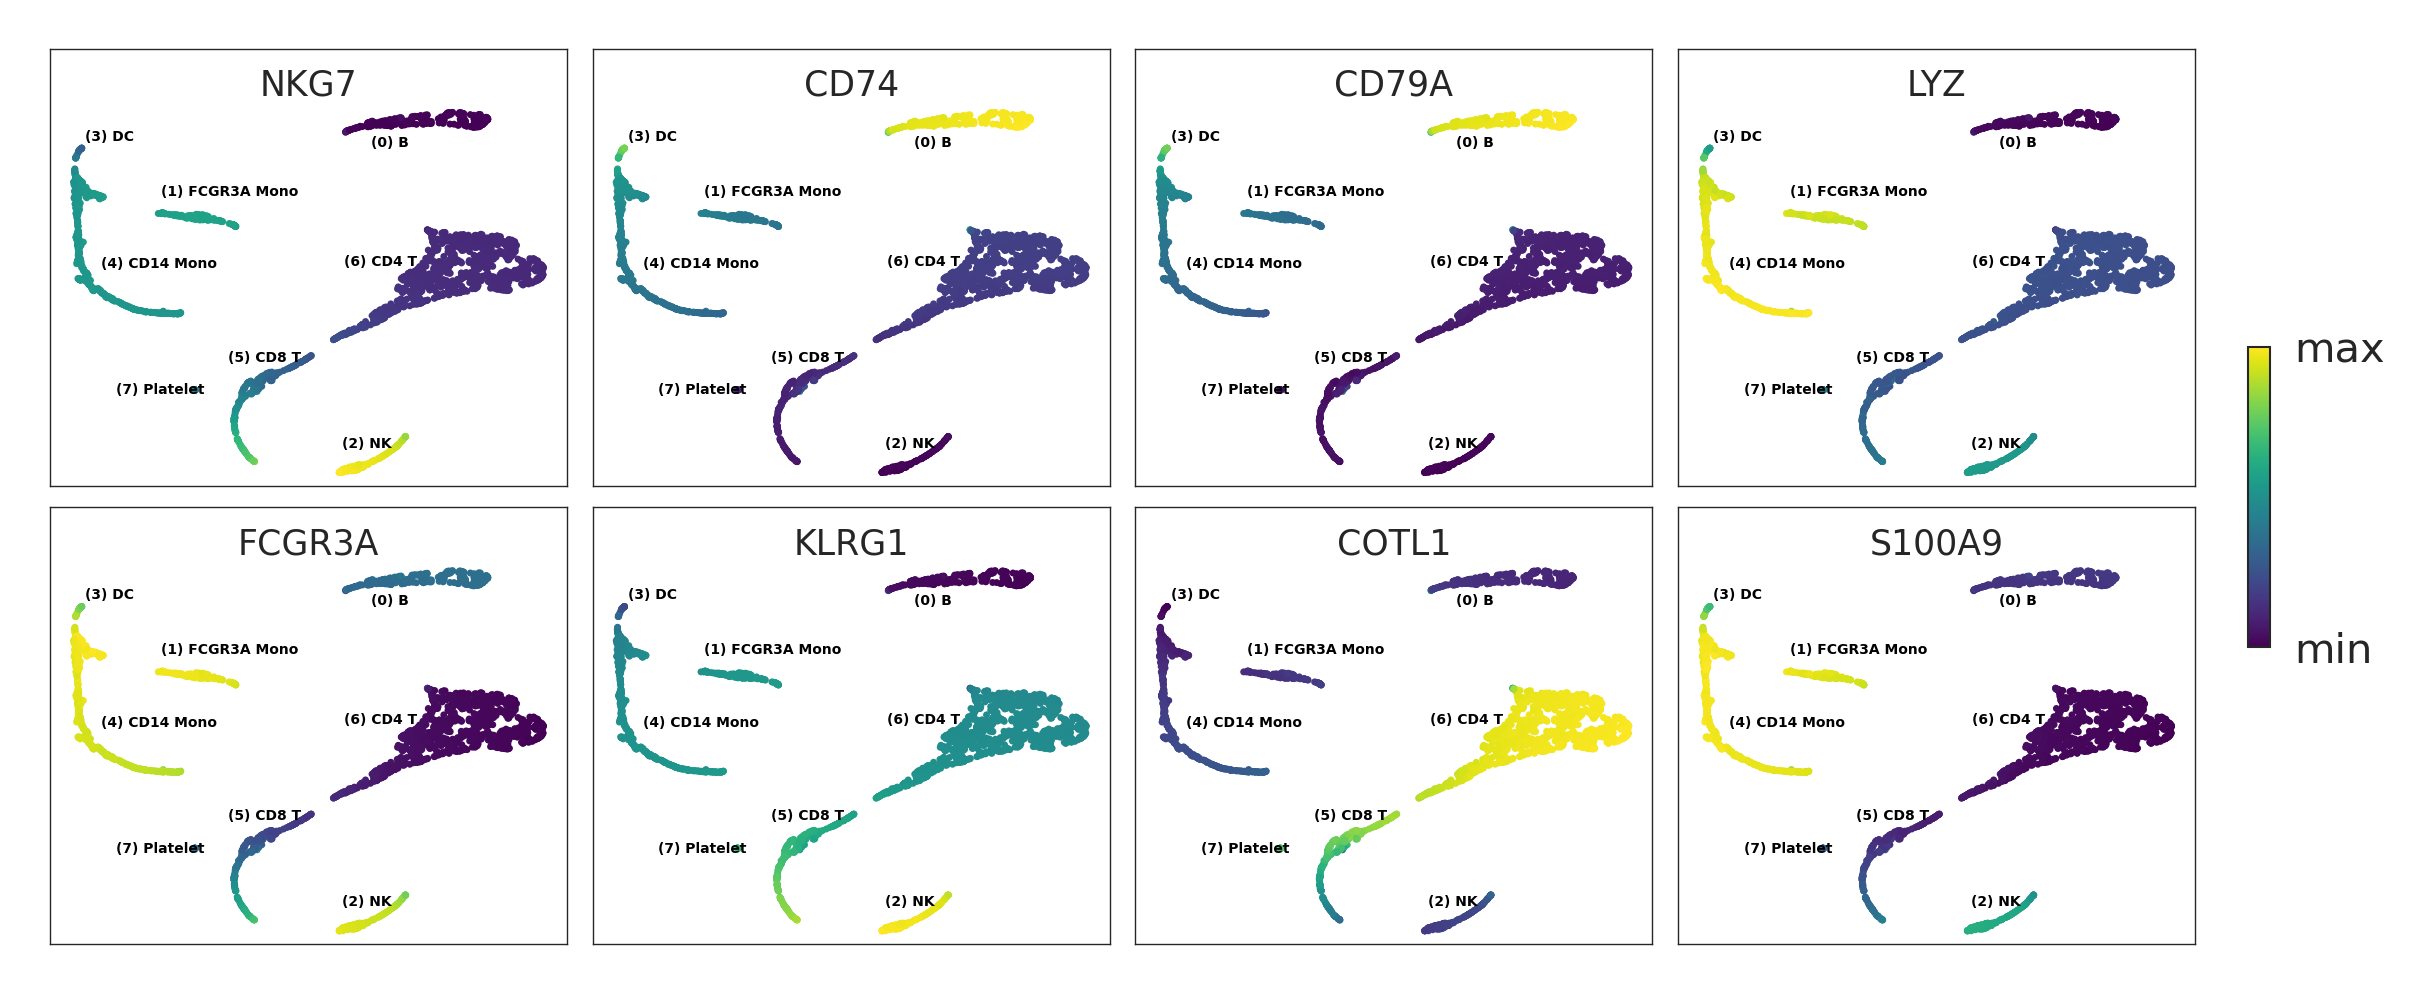

In [19]:
sns.set_style('white')
fig, axs = plt.subplots(2, 4, figsize=(4.5, 2))

for i, (gene, hue) in enumerate(genes_to_hues.items()):
    ax = axs.reshape(-1)[i]
    plt.setp(ax, ylim=(-10, 26))
    sns.scatterplot(ax=ax, x=cellvgae_umap[:, 0], y=cellvgae_umap[:, 1], hue=hue, palette="viridis", s=1, edgecolor='black', linewidth=0.0)
    ax.get_legend().remove()
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.spines['left'].set_linewidth(0.2)
    ax.spines['top'].set_linewidth(0.2)
    ax.spines['bottom'].set_linewidth(0.2)
    ax.spines['right'].set_linewidth(0.2)
    
    ax.text(6.5, -6.8, "(2) NK", horizontalalignment='left', size='2', color='black', weight='semibold')
    ax.text(0.5, 0.3, "(5) CD8 T", horizontalalignment='left', size='2', color='black', weight='semibold')
    ax.text(-5.4, -2.4, "(7) Platelet", horizontalalignment='left', size='2', color='black', weight='semibold')
    ax.text(6.6, 8.2, "(6) CD4 T", horizontalalignment='left', size='2', color='black', weight='semibold')
    ax.text(8, 18, "(0) B", horizontalalignment='left', size='2', color='black', weight='semibold')
    ax.text(-3, 14, "(1) FCGR3A Mono", horizontalalignment='left', size='2', color='black', weight='semibold')
    ax.text(-6.2, 8, "(4) CD14 Mono", horizontalalignment='left', size='2', color='black', weight='semibold')
    ax.text(-7, 18.5, "(3) DC", horizontalalignment='left', size='2', color='black', weight='semibold')
    
    ax.set_title(gene, position=(0.5, 0.8), fontdict={'fontsize': 5})
    
# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], cmap='viridis')

# Define a new Axes where the colorbar will go
cax = fig.add_axes([1, .35, .01, .3])

# Draw the colorbar
cbar = fig.colorbar(points, cax=cax)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['min', 'max'])
cbar.ax.tick_params(labelsize=6) 
cbar.ax.tick_params(axis=u'both', which=u'both',length=0)
cbar.outline.set_linewidth(0.3)
    
plt.tight_layout(w_pad=1.5, h_pad=3.5)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
# plt.savefig('gene_heatmaps.pdf', dpi=500, bbox_inches = "tight")

## Particular example

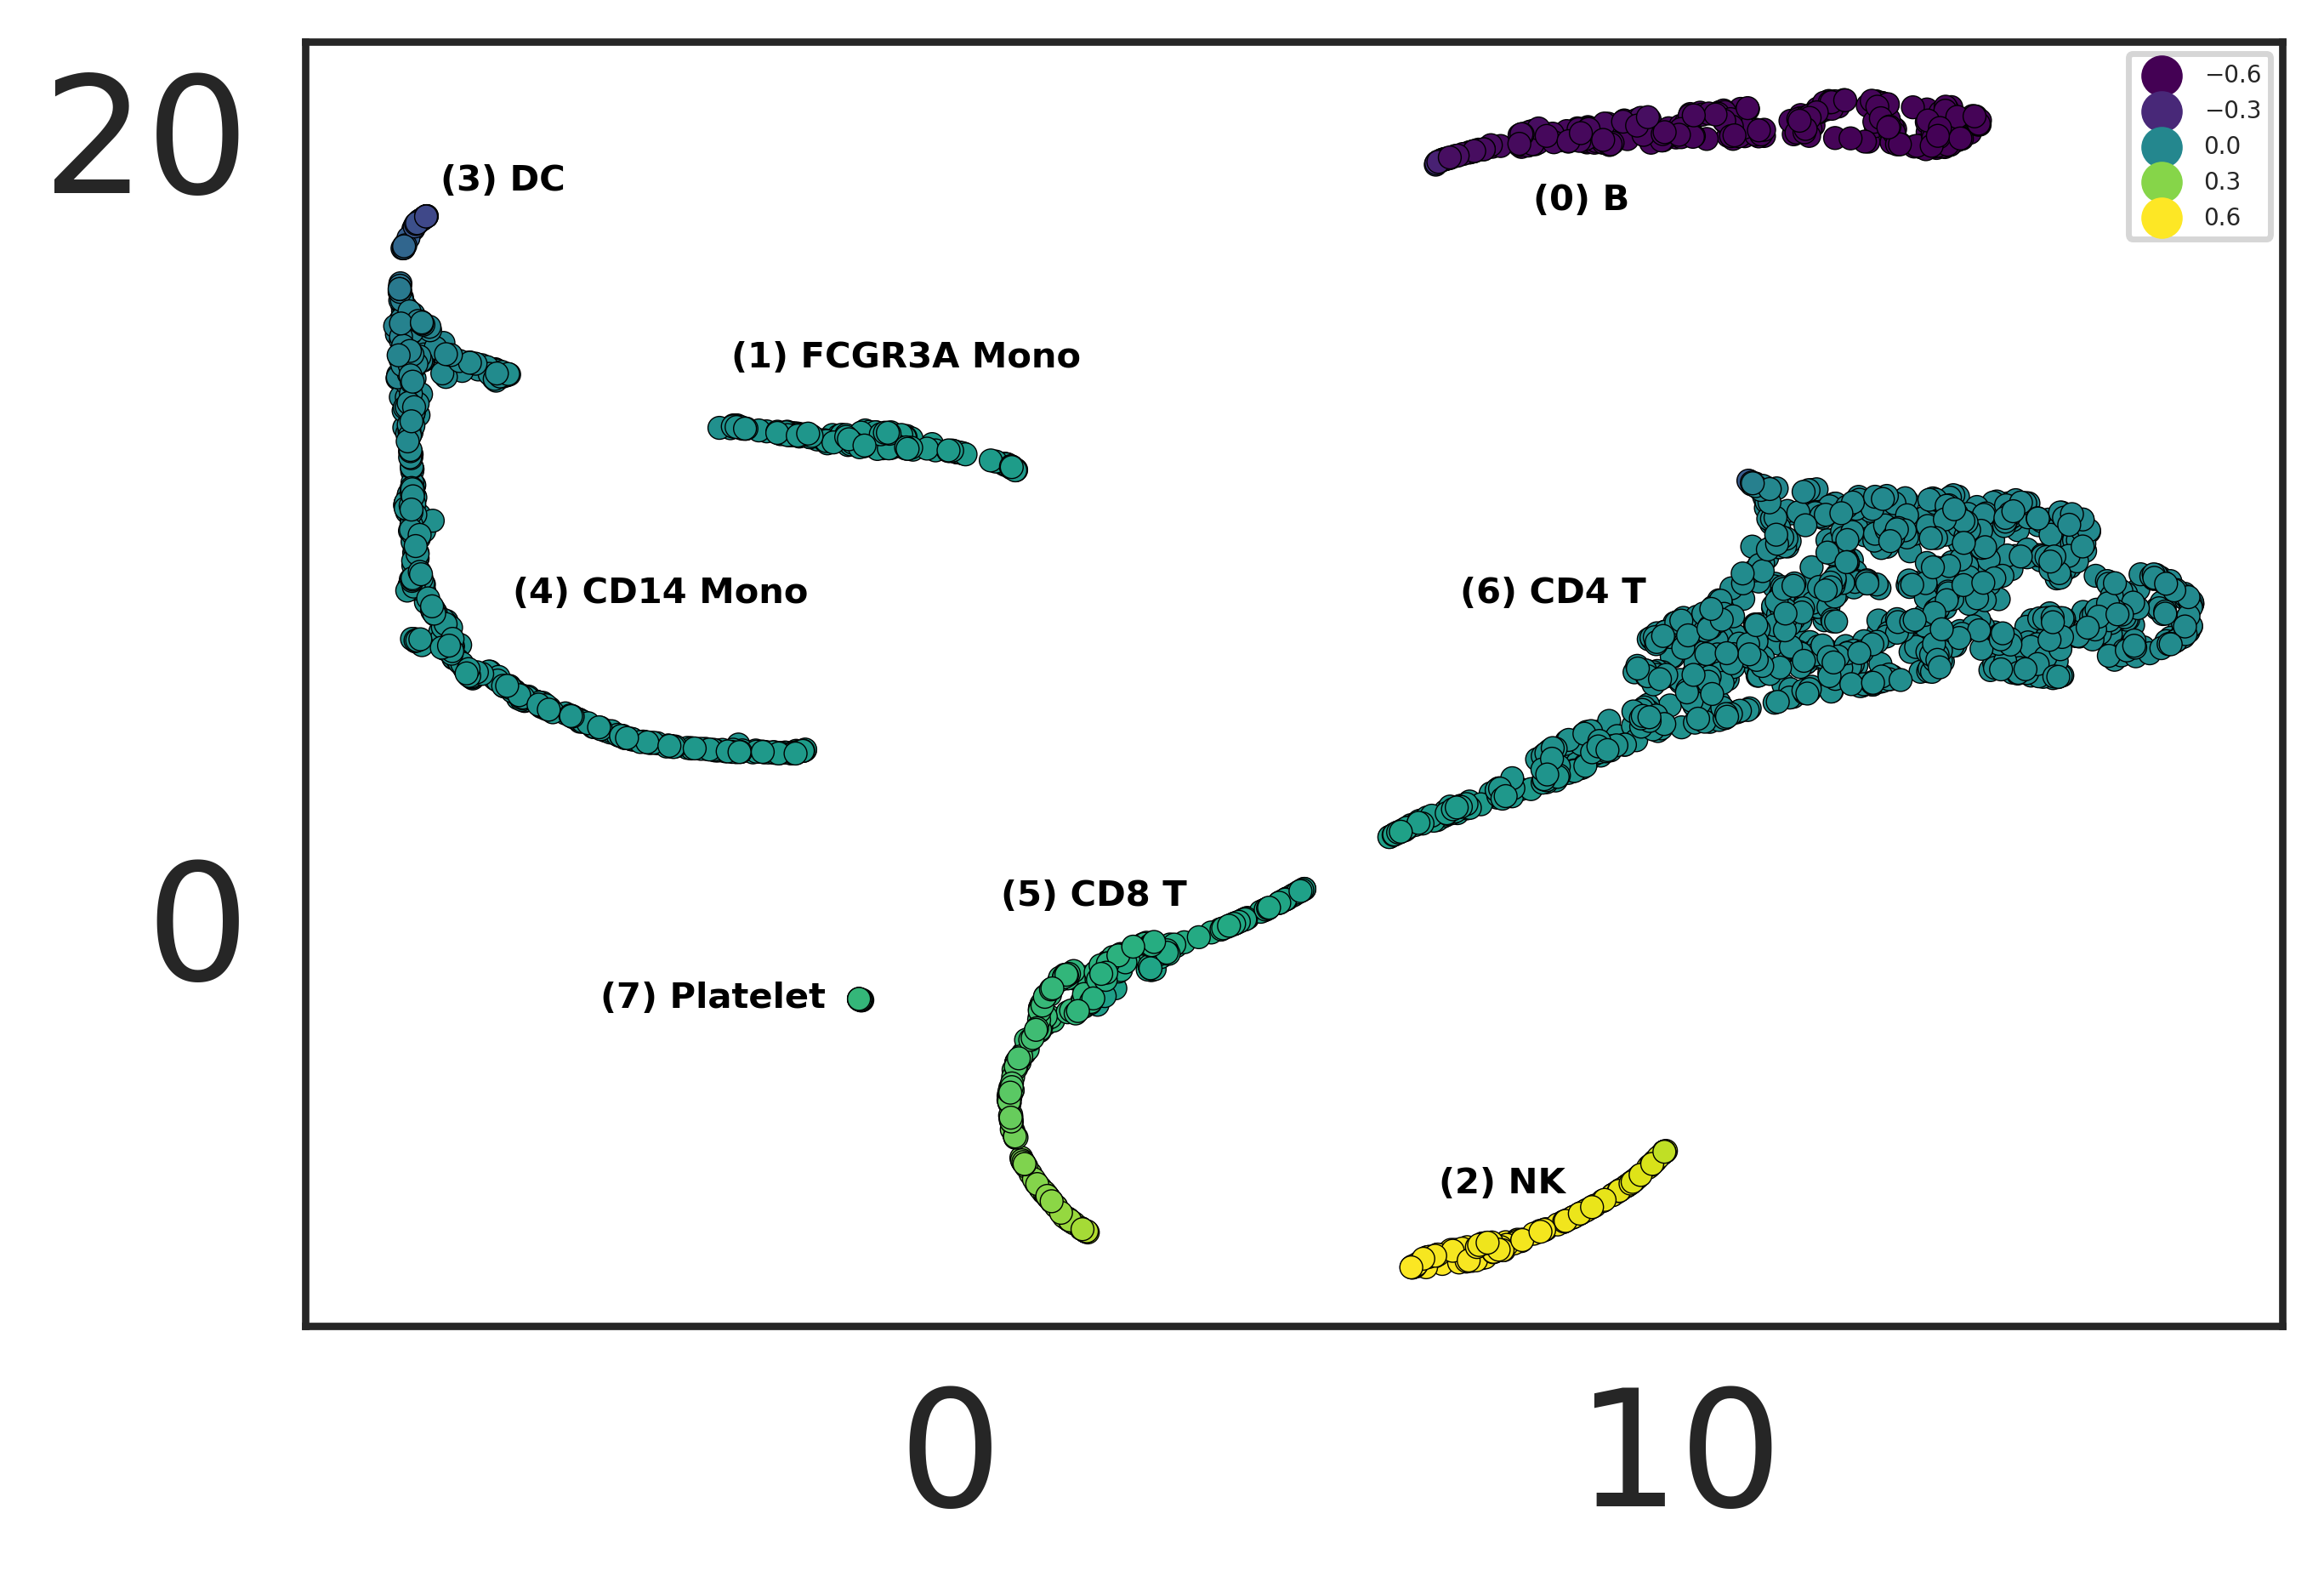

In [20]:
plt.tight_layout(w_pad=1.5, h_pad=3.5)
pl = sns.scatterplot(x=cellvgae_umap[:, 0], y=cellvgae_umap[:, 1], hue=np.matmul(cellvgae_node_embs, merged_mean_layer[gene_to_idx['KLRG1'], :].detach().numpy()), palette="viridis", s=15, edgecolor='black', linewidth=0.2)

pl.text(6.7, -7, "(2) NK", horizontalalignment='left', size='6', color='black', weight='semibold')
pl.text(0.7, 0.3, "(5) CD8 T", horizontalalignment='left', size='6', color='black', weight='semibold')
pl.text(-4.8, -2.3, "(7) Platelet", horizontalalignment='left', size='6', color='black', weight='semibold')
pl.text(7, 8, "(6) CD4 T", horizontalalignment='left', size='6', color='black', weight='semibold')
pl.text(8, 18, "(0) B", horizontalalignment='left', size='6', color='black', weight='semibold')
pl.text(-3, 14, "(1) FCGR3A Mono", horizontalalignment='left', size='6', color='black', weight='semibold')
pl.text(-6, 8, "(4) CD14 Mono", horizontalalignment='left', size='6', color='black', weight='semibold')
pl.text(-7, 18.5, "(3) DC", horizontalalignment='left', size='6', color='black', weight='semibold')

plt.legend(prop={'size': 4})
plt.grid(False)